<a href="https://colab.research.google.com/github/tumanov-a/imdb_sentiment_analys/blob/main/IMDB_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [16]:
reviews = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv.zip', compression='zip')

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
def replace_(fragment):
  fragment = re.sub('<br />', '', fragment)
  return fragment

In [20]:
reviews['review'] = reviews['review'].apply(replace_)
reviews['review'] = reviews['review'].apply(lambda x: x[:512])
reviews['sentiment'] = reviews['sentiment'].map({'positive': 1, 'negative': 0})

In [21]:
reviews['review'] = reviews['review'].apply(lambda x: '[CLS] ' + x + ' [SEP]')

In [22]:
x, y = reviews.review, reviews.sentiment

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [23]:
!pip install pytorch_transformers

In [24]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in x_train]

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, 
                          dtype='long', 
                          padding='post', 
                          truncating='post')

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, y_train, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.1)

train_labels, validation_labels = np.array(train_labels), np.array(validation_labels)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=16,
    sampler=torch.utils.data.RandomSampler(train_data)
)

validation_data = torch.utils.data.TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=16,
    sampler=torch.utils.data.SequentialSampler(validation_data)
)

In [27]:
from pytorch_transformers import AdamW, BertForSequenceClassification, BertModel

In [28]:
class myBertModel(torch.nn.Module):
  def __init__(self, hidden_neurons):
    super(myBertModel, self).__init__()
    config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)
    self.model = BertModel.from_pretrained('bert-base-uncased', config=config)
    self.hidden_neurons = hidden_neurons
    self.linear_1 = torch.nn.Linear(config.hidden_size, self.hidden_neurons)
    self.linear_2 = torch.nn.Linear(self.hidden_neurons, int(self.hidden_neurons / 2))
    self.classifier = torch.nn.Linear(int(self.hidden_neurons / 2), 2)
    self.activation = torch.nn.Sigmoid()
    self.dropout = torch.nn.Dropout(.3)

  def forward(self, features, attention_mask):
    bert_output = self.model(input_ids=features, attention_mask=attention_mask)
    seq_output = bert_output[0]
    pooled_output = seq_output.mean(axis=1)
    pooled_output = self.dropout(pooled_output)
    linear_output = self.linear_1(pooled_output)
    linear_output_2 = self.linear_2(linear_output)
    scores = self.classifier(linear_output_2)
    scores = self.dropout(scores)
    scores = self.activation(scores)
    return scores

my_model = myBertModel(384)

100%|██████████| 440473133/440473133 [00:47<00:00, 9179734.67B/s] 


In [29]:
optimizer = AdamW(my_model.parameters(), lr=2e-5)
loss = torch.nn.CrossEntropyLoss()

In [30]:
my_model.cuda()
my_model.train()

myBertModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [31]:
from tqdm import tqdm

In [32]:
loss_set = []
my_model.train()

for epoch in tqdm(range(2)):
  for batch in train_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    pred_labels = my_model.forward(b_input_ids, b_input_mask)
    my_loss = loss(pred_labels, b_labels)
    loss_set.append(my_loss.item())
    my_loss.backward()
    optimizer.step()

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
100%|██████████| 2/2 [28:23<00:00, 851.67s/it]


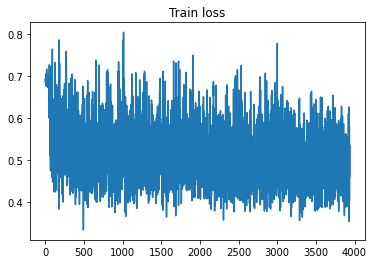

In [33]:
plt.plot(loss_set)
plt.title('Train loss')
plt.show()

In [34]:
my_model.eval()

test_preds, test_labels, test_probs = [], [], []

for batch in tqdm(validation_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    pred_labels = my_model.forward(b_input_ids, b_input_mask)

  b_labels = b_labels.to('cpu').numpy()
  pred_labels = pred_labels.to('cpu').numpy()

  test_probs.extend(pred_labels)
  pred_labels = pred_labels.argmax(axis=1)
  
  test_labels.extend(b_labels)
  test_preds.extend(pred_labels)

100%|██████████| 219/219 [00:29<00:00,  7.34it/s]


In [36]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score

test_probs = [list(probs) for probs in test_probs]
test_probs_f = np.array(test_probs)[:, 1]

print(classification_report(test_labels, test_preds))
print('roc_auc ', round(roc_auc_score(test_labels, test_probs_f), 2))
print('f1 ', round(f1_score(test_labels, test_preds), 2))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1758
           1       0.88      0.87      0.88      1742

    accuracy                           0.88      3500
   macro avg       0.88      0.88      0.88      3500
weighted avg       0.88      0.88      0.88      3500

roc_auc  0.95
f1  0.88
